In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
#os.chdir(os.getcwd()+'/outputs/3_2_1_strategic_decisions')

In [3]:
K_set = 1
T_set = 10
I_set = 4

In [4]:
dem_dictionary_k = {1: [40000, 80000, 50000]
}

#define supply attributes
#base capacity
cap_dictionary_supplier_SKU = {1: [9000,11000,10000], #min, max, likely, a,b,c
                     2: [10000,20000,15000], 
                     3: [13000,20000,17000],
                    4: [40000,100000,60000]}

#increase N-95 MG
#cap_dictionary_supplier_SKU = {1: [18000,22000,20000], #min, max, likely, a,b,c
#                     2: [10000,20000,15000], 
#                     3: [13000,20000,17000],
#                     4: [40000,100000,60000]}

#increase SURG
#cap_dictionary_supplier_SKU = {1: [9000,11000,10000], #min, max, likely, a,b,c
#                 2: [10000,20000,15000], 
#                 3: [13000,20000,17000],
#                 4: [50000,110000,70000]}

#increase both
#cap_dictionary_supplier_SKU = {1: [18000,22000,20000], #min, max, likely, a,b,c
#                 2: [10000,20000,15000], 
#                 3: [13000,20000,17000],
#                 4: [50000,110000,70000]}

#lead-time
lead_time_dictionary_supplier_SKU = {1: [3,5,4], #min, max, likely, a,b,c
                     2: [1,3,2], 
                     3: [3,5,4],
                     4: [0,2,0]}

#dynamic adj
#dynamic_adj_dem = [0.6, 0.85, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.5, 0.55] #surge
dynamic_adj_dem = [0.5, 0.55, 0.6, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.85] #original
dynamic_adj_supply = np.zeros(T_set)
for t in range(1, T_set+1):
    if dynamic_adj_dem[t-1] < 1:
        dynamic_adj_supply[t-1] = 1+(1-dynamic_adj_dem[t-1])
    else:
        dynamic_adj_supply[t-1] = 2-dynamic_adj_dem[t-1]

budget = 800000
warehouse_cap_level = 1.5 #time intervals of expected supply needed that can be stored
reliability_level = .75
dynamic = True

#supplier-SKU names
names_supplier_SKU = ['Supplier 1 - SKU: N95-MG', 'Supplier 1 - SKU: N95-N', 
 'Supplier 2 - SKU: SUR-MG', 'Supplier 2 - SKU: SUR-N']

In [5]:
def triangular_dist_demand(a,b,c,prob):
    if prob <= (c-a)/(b-a):
        return(a+((((prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((1-prob)*(b-a)*(b-c))**(1/2)))

In [6]:
def triangular_dist_supply(a,b,c,prob):
    if 1-prob <= (c-a)/(b-a):
        return(a+((((1-prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((prob)*(b-a)*(b-c))**(1/2)))

In [7]:
def lead_time_dist(a,b,c):
    lead_time_dist_array = np.zeros(T_set+1)
    cum_prob = 0
    t = 0
    
    while t < b+1:
        if t+1 <= a:
            t = t+1 
        elif (a < t+1 & t+1 <= c):
            cum_prob_temp = ((t+1-a)**2)/((b+1-a)*(c-a))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
        elif c < t+1 & t+1 <= b+1:
            cum_prob_temp = 1-((b+1-(t+1))**2)/((b+1-a)*(b+1-c))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
    
    return(lead_time_dist_array)

In [8]:
k = 1

#define parameters

###health care commodity metric parameters####
#rank
r_k_dict = {
    1 : 1
}

#quality 
q_i_dict = {
    1 : 3,
    2: 2,
    3: 2,
    4: 1
}


####Supply Parameters#####

#lead time (supplier 3 has the lowest lead time)
f_i_tDiff_dict = {}
for i in range(1,I_set+1):
    lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                         lead_time_dictionary_supplier_SKU.get(i)[1],
                                         lead_time_dictionary_supplier_SKU.get(i)[2])
    for t in range(0,T_set+1):
                f_i_tDiff_dict[tuple([i,t])] = lead_time_dist_array[t]


#incoming orders
o_i_t_init_dict = {}


for i in range(1,I_set+1):
    for t in range(1,T_set+1):
        if t <= 2:
            o_i_t_init_dict[tuple([i,t])] = 0 #20000/4 #5000
        else:
            o_i_t_init_dict[tuple([i,t])] = 0



#lead time (supplier 1 has the higest capacity)
CAP_i_t_dict = {}

for i in range(1,I_set+1):
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      reliability_level)
    if (dynamic == True):
        for t in range(1,T_set+1):
            cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
            CAP_i_t_dict[tuple([i,t])] = cap_temp_2
    else:
        for t in range(1,T_set+1):
            CAP_i_t_dict[tuple([i,t])] = cap_temp

####Demand Parameters####
n_k_init_dict = {
    1 : 0
}


#demand RV
D_k_t_dict = {}
demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                     dem_dictionary_k.get(k)[1],
                                     dem_dictionary_k.get(k)[2],
                                     reliability_level)

if (dynamic == True):
    for t in range(1,T_set+1):
        demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
        D_k_t_dict[tuple([k,t])] = demand_temp_2
else:
    for t in range(1,T_set+1):
        D_k_t_dict[tuple([k,t])] = demand_temp


#starting inventory
z_i_init_dict = {
    1 : 8000,
    2 : 8000,
    3 : 8000,
    4 : 8000
}

#size
s_i_dict = {
    1 : 1,
    2 : 1,
    3 : 1,
    4 : 1
}

#warehouse capacity
h = 80000*warehouse_cap_level 

#cost (supplier 2 has the lowest cost)
c_i_dict = {
    1 : 2,
    2 : 1.5,
    3 : 1,
    4 : .8
}

b = budget

In [9]:
model = ConcreteModel()

#####define sets#######
model.K = Set(initialize = range(1,K_set+1))
model.I = Set(initialize = range(1,I_set+1))
model.T = Set(initialize = range(1,T_set+1))
model.T_0 = Set(initialize = range(0,T_set+1))

####initialize parameters####

def rank_param_initialize(model, k):
    return(r_k_dict.get(k))

model.r_k = Param(model.K, initialize = rank_param_initialize)

def discount_param_initialize(model, k, t):
    discount_temp = 1/model.r_k[k]
    numerator = ((1+discount_temp)**T_set)
    denominator = ((1+discount_temp)**(t-1))
    
    return(numerator/denominator)

model.tau_k_t = Param(model.K, model.T, initialize = discount_param_initialize)

#model.tau_k_t.pprint()

def quality_param_initialize(model, i):
    return(q_i_dict.get(i))

model.q_i = Param(model.I, initialize = quality_param_initialize)

#model.q_k_i.pprint()

def delay_dist_param_initialize(model, i, t):
    return(f_i_tDiff_dict.get(tuple([i,t])))

model.f_i_tDiff = Param(model.I, model.T_0, 
                          initialize = delay_dist_param_initialize)

#model.f_k_i_tDiff.pprint()

def incoming_orders_initialize(model, i, t):
    return(o_i_t_init_dict.get(tuple([i,t])))

model.o_i_t_init = Param(model.I, model.T, initialize = incoming_orders_initialize)

#model.o_k_i_t.pprint()

def supplier_cap_param_initialize(model, i, t):
    return(CAP_i_t_dict.get(tuple([i,t])))

model.cap_i_t = Param(model.I, model.T, initialize = supplier_cap_param_initialize)

#model.cap_k_i_t.pprint()

def unfulfilled_demand_param_initialize(model, k):
    return(n_k_init_dict.get(k))

model.n_k_init = Param(model.K, initialize = unfulfilled_demand_param_initialize)

#model.n_k_intialize.pprint()

#assume preparing for one sd above the mean
def demand_param_initialize(model, k, t):
    return(D_k_t_dict.get(tuple([k,t])))

model.d_k_t = Param(model.K, model.T, initialize = demand_param_initialize)

#model.d_k_t.pprint()

def beg_inv_param_initialize(model, i):
    return(z_i_init_dict.get(i))

model.z_i_init = Param(model.I, initialize = beg_inv_param_initialize)

#model.z_k_i_init.pprint()

def item_size_param_initialize(model, i):
    return(s_i_dict.get(i))

model.s_i = Param(model.I, initialize = item_size_param_initialize)

#model.s_k.pprint()

def warehouse_cap_param_initialize(model):
    return(h)

model.h = Param(initialize = h)

#model.h.pprint()

def cost_param_initialize(model, i):
    return(c_i_dict.get(1))

model.c_i = Param(model.I, initialize = cost_param_initialize)

#model.c_k_i.pprint()

def budget_param_initialize(model):
    return(b)

model.b = Param(initialize = budget_param_initialize)

#model.b.pprint()

####initialize variables####
model.x_i_t = Var(model.I, model.T, within = NonNegativeReals) #amount ordered
model.y_i_t = Var(model.I, model.T, within = NonNegativeReals) #amount recieved
model.z_i_t = Var(model.I, model.T, within = NonNegativeReals)
model.n_k_t = Var(model.K, model.T, within = NonNegativeReals)
model.m_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)

In [10]:
model.d_k_t.pprint()

d_k_t : Size=10, Index=d_k_t_index, Domain=Any, Default=None, Mutable=False
    Key     : Value
     (1, 1) :  31339.74596215561
     (1, 2) :  34473.72055837118
     (1, 3) : 37607.695154586734
     (1, 4) :  62679.49192431122
     (1, 5) :  68947.44111674235
     (1, 6) :  94019.23788646684
     (1, 7) : 100287.18707889796
     (1, 8) :  75215.39030917347
     (1, 9) :  68947.44111674235
    (1, 10) :  53277.56813566454


In [11]:
#def initialize_objective(model):
model.Objective = Objective(expr = 
                            (sum(model.q_i[i]*sum(model.tau_k_t[k,t]*model.m_k_i_t[k,i,t] 
                                                      for t in model.T) 
                                 for i in model.I for k in model.K)),
                            sense = maximize)

In [12]:
def initalize_unsatisfied_demand_constraint_initialize(model, k):
    return(model.n_k_t[k,1] == model.n_k_init[k])

model.initalize_unsatisfied_demand_constraint= \
Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
    if (t == 1):
        return(sum(model.m_k_i_t[k,i,t] for i in model.I) <= model.n_k_t[k,t] + model.d_k_t[k,t])
    else:
        return(model.n_k_t[k,t] == model.n_k_t[k,t-1] + model.d_k_t[k,t] \
               - sum(model.m_k_i_t[k,i,t] for i in model.I))

model.calculate_unsatisfied_demand_constraint = \
Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)

def supplier_constraint_initialize(model, i, t):
    return(model.x_i_t[i,t] <= model.cap_i_t[i,t])

model.supplier_constraint = \
Constraint( model.I, model.T, rule = supplier_constraint_initialize)

def incoming_orders_constraint_initialize(model, i, t):
    return(model.y_i_t[i,t] - 
           sum(model.f_i_tDiff[i, t-t_ordered_time]*model.x_i_t[i,t_ordered_time] 
               for t_ordered_time in range(1,t+1)) - model.o_i_t_init[i,t] == 0)

model.incoming_ordered_constraint = Constraint(model.I, model.T, 
                                               rule = incoming_orders_constraint_initialize)

def beggining_inventory_constraint_initialize(model, i):
    return(model.z_i_t[i,1] == model.z_i_init[i])
    
model.beggining_inventory_constraint = Constraint(model.I, 
                                                  rule = beggining_inventory_constraint_initialize)

def calculate_available_inventory_constraint_initialize(model, i, t):
    if (t > 1):
        return(model.z_i_t[i,t] == model.z_i_t[i,t-1] + model.y_i_t[i,t-1] - \
               sum(model.m_k_i_t[k,i,t-1] for k in model.K))
    else:
        return(Constraint.Skip)
    
model.calculate_available_inventory_constraint = Constraint(model.I, model.T,
                                                            rule = 
                                                            calculate_available_inventory_constraint_initialize)

def cannot_fulfill_more_than_available_constraint_initialize(model, i, t):
    return(sum(model.m_k_i_t[k,i,t] for k in model.K) - model.z_i_t[i,t] <= 0)

model.cannot_fulfill_more_than_available_constraint = \
Constraint(model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

def warehouse_capacity_constraint_initialize(model, t):
    return(sum(model.s_i[i]*model.z_i_t[i,t] for i in model.I) <= model.h)

model.warehouse_capacity_constraint = \
Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

def budget_constraint_initialize(model):
    return(sum(model.c_i[i]*model.x_i_t[i,t] 
               for i in model.I for t in model.T) 
           <= model.b)

model.budget_constraint = \
Constraint(rule = budget_constraint_initialize)

In [13]:
opt = SolverFactory('gurobi_persistent')
opt.set_instance(model)
opt.solve(model)

Using license file /Users/chelseagreene/gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-20


{'Problem': [{'Name': 'unknown', 'Lower bound': 120303063.36508656, 'Upper bound': 120303063.36508656, 'Number of objectives': 1, 'Number of constraints': 182, 'Number of variables': 170, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 170, 'Number of nonzeros': 535, 'Sense': -1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.10', 'Status': 'ok', 'Wallclock time': 0.0014531612396240234, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [14]:
#extract ordering df
ordered_df = pd.DataFrame(list(model.x_i_t.extract_values().items()),columns = ['sets','units_to_order'])
ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[0])
ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[1])

In [15]:
#extract expected arrivals df
recieved_df = pd.DataFrame(list(model.y_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[0])
recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[1])

In [16]:
#extract expected fulfilled df
fulfilled_df = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
#fulfilled_df['delay'] = fulfilled_df['time_interval'] - fulfilled_df['time_interval_req']

In [17]:
#extract expected available df
available_df = pd.DataFrame(list(model.z_i_t.extract_values().items()),columns = ['sets','units_available'])
available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[0])
available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[1])

In [18]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

In [19]:
demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])

In [20]:
ordered_and_recieved_df = ordered_df[['supplier', 'time_interval', 'sets']]
ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                        on='sets', how='left')
ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                        on='sets', how='left')

ordered_and_recieved_df = ordered_and_recieved_df[['supplier', 
                                                   'time_interval','units_to_order', 
                                                   'expected_units_recieved']]

ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)

In [21]:
#os.chdir(results_dir)
#ordered_and_recieved_df.to_csv('ordering_and_recieving_schedule.csv')

#recieved_df.to_csv('recieving_schedule.csv')
#ordered_df.to_csv('ordering_schedule.csv')

In [22]:
#for k in range(1,K+1):
unsatisfied_temp_df = unsatisfied_df[unsatisfied_df['item_type'] == 1].groupby(['time_interval'])['units_unsatisfied']\
.sum().reset_index()
fulfilled_temp_df = fulfilled_df[fulfilled_df['item_type'] == 1].groupby(['time_interval'])["units_fulfilled"]\
.sum().reset_index()
available_temp_df = available_df.groupby(['time_interval'])["units_available"]\
.sum().reset_index()

In [23]:
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')

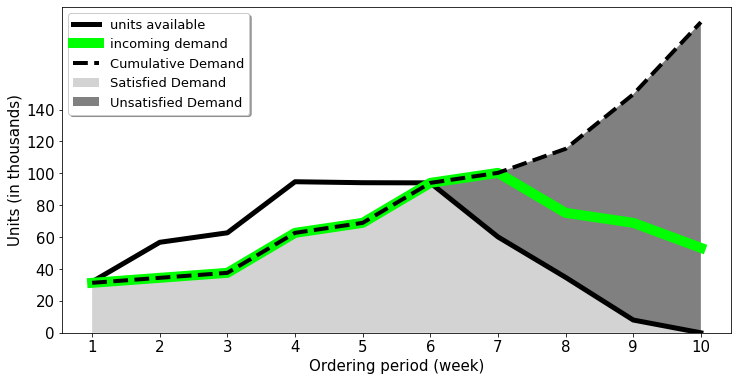

In [24]:
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')

fig2, ax2 = plot.subplots(figsize=(12,6))

ax2.plot(available_temp_df['time_interval'], 
          available_temp_df['units_available']/1000, 
          label='units available',
          color ="black",
         linewidth=5) 

ax2.plot(demand_df['time_interval'], 
         (demand_df['demand_in_units'])/1000 , 
         label='incoming demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
         linewidth=10,
         color = "lime")

ax2.plot(demand_df['time_interval'], 
         (temp_all['units_unsatisfied']+temp_all['units_fulfilled'])/1000, 
         label='Cumulative Demand',
         linewidth=4,
         color = "black",
         linestyle='dashed')

# Your x and y axis
x=range(1,T_set+1)
y=[temp_all['units_fulfilled']/1000, temp_all['units_unsatisfied']/1000]
 
# use a known color palette (see..)
pal = ["#D3D3D3", "#808080"]
plot.stackplot(x,y, labels=['Satisfied Demand', 'Unsatisfied Demand'], colors=pal)
plot.legend(loc='upper right')
plot.xticks(fontsize= 15)
plot.yticks(fontsize= 15)
ax2.xaxis.set_ticks(np.arange(1, T_set+1, 1))
ax2.yaxis.set_ticks(np.arange(0, 160, 20))

ax2.set_xlabel('Ordering period (week)', fontsize=15)
ax2.set_ylabel('Units (in thousands)', fontsize=15)
#ax2.set_title('Option 1: Budget of \$700,000 and renew lease', fontsize = 15)
#ax2.set_title('Available, Unsatisfied, and Satisfied Units of Masks (k=1) \n summed over all suppliers (i) at each Time Interval (t)\
#\n medium supplier risk, medium demand reliability', fontsize='xx-large')
#ax2.set_title('Available, Unsatisfied, and Satisfied Units of Masks during each Time Interval\
#\n Assuming Average (no variation) Supplier Capacity and Demand Projections, \n \
#and a Budget of \$80,000 over 10 Weeks', fontsize=24)
ax2.legend(loc='upper left', shadow=True, fontsize=13)


plot.savefig('700K_overtime.jpg')
#plot.savefig('500K_overtime.jpg')

In [25]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

#for k in range(1,K+1):
unsatisfied_temp_df = unsatisfied_df[unsatisfied_df['item_type'] == 1].groupby(['time_interval'])['units_unsatisfied']\
.sum().reset_index()
fulfilled_temp_df = fulfilled_df[fulfilled_df['item_type'] == 1].groupby(['time_interval'])["units_fulfilled"]\
.sum().reset_index()
available_temp_df = available_df.groupby(['time_interval'])["units_available"]\
.sum().reset_index()
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')
temp_all['percent_unsatisfied'] = temp_all['units_unsatisfied']/(temp_all['units_fulfilled'] + temp_all['units_unsatisfied'])
temp_all['stacked'] = temp_all['units_fulfilled'] + temp_all['units_unsatisfied']

In [26]:
units = []
name = []
time_interval = []

In [27]:
for i in fulfilled_df.index:
    units.append(fulfilled_df['units_fulfilled'].iloc[i])
    time_interval.append(fulfilled_df['time_interval'].iloc[i])
    if (fulfilled_df['supplier'].iloc[i] == 1):
        name.append('SKU: N95-MG')
    elif (fulfilled_df['supplier'].iloc[i] == 2):
        name.append('SKU: N95-N')
    elif (fulfilled_df['supplier'].iloc[i] == 3):
        name.append('SKU: SUR-MG')
    else:
        name.append('SKU: SUR-N')

        
for i in unsatisfied_df.index:
    units.append(unsatisfied_df['units_unsatisfied'].iloc[i])
    time_interval.append(unsatisfied_df['time_interval'].iloc[i])
    name.append('unsatisfied_demand')

In [28]:
stacked_temp = pd.DataFrame(list(zip(name, time_interval, units)), 
                    columns =['name', 'time_interval', 'units']).groupby(['time_interval', 'name']).sum()\
.reset_index()

In [29]:
stacked_temp['units'] = stacked_temp['units']/1000

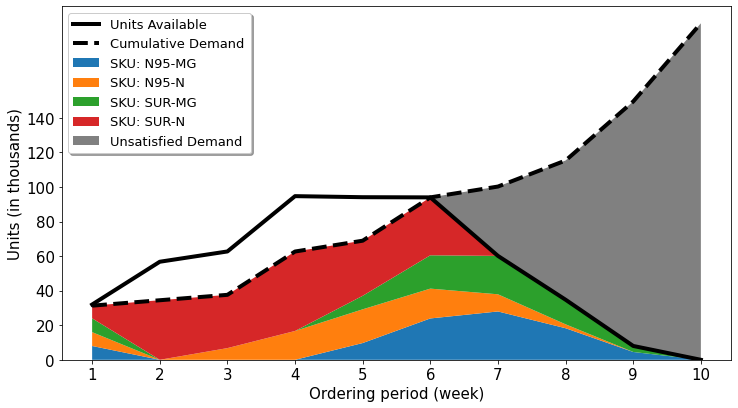

In [30]:
fig2, ax3 = plot.subplots(figsize=(12,6.5))

ax3.plot(available_temp_df['time_interval'], 
          available_temp_df['units_available']/1000,  
          label='Units Available',
          color ="black",
         linewidth=4) 

#ax3.plot(demand_df['time_interval'], 
#         (demand_df['demand_in_units'])/1000 , 
#         label='incoming demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
#         linewidth=5,
#         color = "#fb169b")

ax3.plot(demand_df['time_interval'], 
         (temp_all['units_fulfilled']+temp_all['units_unsatisfied'])/1000, 
         label='Cumulative Demand',
         linewidth=4,
         color = "black",
         linestyle='dashed')

# Your x and y axis
x=range(1,T_set+1)
y=[stacked_temp[stacked_temp['name'] == 'SKU: N95-MG']['units'], stacked_temp[stacked_temp['name'] == 'SKU: N95-N']['units'],
  stacked_temp[stacked_temp['name'] == 'SKU: SUR-MG']['units'], stacked_temp[stacked_temp['name'] == 'SKU: SUR-N']['units'],
  stacked_temp[stacked_temp['name'] == 'unsatisfied_demand']['units']]
 
# use a known color palette (see..)
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
#ax3.stackplot(x,y)#, labels=['High Capacity R US (Surgical Masks)', 'Affordable PPE (Cloth Masks)', 'Speedy Industries (Surgical Masks)', 
                            #'High Quality Inc. (N95 Masks)', 'Unsatisfied Demand '], colors=pal)#, alpha=0.4)
ax3.stackplot(x,y, labels=['SKU: N95-MG', 'SKU: N95-N', 'SKU: SUR-MG', 
                            'SKU: SUR-N', 'Unsatisfied Demand '], colors=pal)#, alpha=0.4)

plot.xticks(fontsize= 15)
plot.yticks(fontsize= 15)

ax3.xaxis.set_ticks(np.arange(1, T_set+1, 1))
ax3.yaxis.set_ticks(np.arange(0, 160, 20))
#ax3.yaxis.set_ticks(np.arange(0, 100000, 10000))


ax3.set_xlabel('Ordering period (week)', fontsize=15)
ax3.set_ylabel('Units (in thousands)', fontsize=15)
#ax3.set_title('Option 1: Budget of \$700,000 and renew lease \n by supplier-SKU identified for fulfilling orders', fontsize = 15)
#ax3.set_title('Available, Unsatisfied, and Satisfied Units of Masks from each Supplier during each Time Interval\
#\nAssuming Average (no variation) Supplier Capacity and Demand Projections, \n \
#and a Budget of \$80,000 over 10 Weeks', fontsize=24)
ax3.legend(loc='upper left', shadow=True, fontsize=13)
plot.savefig('700K_overtime_supplier.jpg')
#plot.savefig('500K_overtime_supplier.jpg')

In [39]:
demand_df

,sets,demand_in_units,item_type,time_interval
0,"(1, 1)",31339.745962,1,1
1,"(1, 2)",34473.720558,1,2
2,"(1, 3)",37607.695155,1,3
3,"(1, 4)",62679.491924,1,4
4,"(1, 5)",68947.441117,1,5
5,"(1, 6)",94019.237886,1,6
6,"(1, 7)",100287.187079,1,7
7,"(1, 8)",75215.390309,1,8
8,"(1, 9)",68947.441117,1,9
9,"(1, 10)",53277.568136,1,10


In [40]:
fulfilled_df

,sets,units_fulfilled,item_type,supplier,time_interval
0,"(1, 1, 1)",8000.000000,1,1,1
1,"(1, 1, 2)",0.000000,1,1,2
2,"(1, 1, 3)",0.000000,1,1,3
3,"(1, 1, 4)",0.000000,1,1,4
4,"(1, 1, 5)",9707.106781,1,1,5
5,"(1, 1, 6)",23944.196727,1,1,6
6,"(1, 1, 7)",27988.824552,1,1,7
7,"(1, 1, 8)",18281.717771,1,1,8
8,"(1, 1, 9)",4529.983165,1,1,9
9,"(1, 1, 10)",0.000000,1,1,10
